In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import sbi.utils as utils
import corner
import pickle
from sbi import analysis as analysis
from sbi.inference.base import infer

In [2]:
# Load data
df = pd.read_csv('/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/edr3_mock_field_newClusters_ageSpread.csv')

In [3]:
df.shape

(571053, 43)

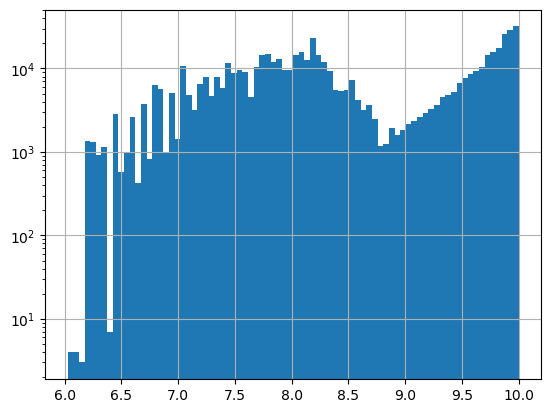

In [4]:
df.logAge.hist(bins=80, log=True);

In [5]:
features_X = [
    # 'parallax_obs', 
    'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs', 'phot_rp_mean_mag_obs',
    'j_obs', 'h_obs', 'k_obs', 
    'w1_obs', 'w2_obs', 'w3_obs', 'w4_obs',
    'irac1_obs', 'irac2_obs', 'irac3_obs', 'irac4_obs', 'mips1_obs', 
    # Errors
    # 'parallax_error',
    'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error', 
    'j_error', 'h_error', 'k_error',
    'w1_error', 'w2_error', 'w3_error', 'w4_error',
    'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error', 'mips1_error'
]

features_y = ['parallax', 'logAge', 'A_V', 'feh']

In [6]:
df[features_y].max()

parallax    252.214920
logAge       10.000000
A_V          12.052591
feh           0.299984
dtype: float64

In [7]:
x_orig = torch.tensor(df[features_X].values.astype(np.float32))
theta_orig = torch.tensor(df[features_y].values.astype(np.float32))

# Normalize the data

In [8]:
x_mean = x_orig.mean(dim=0)
x_std = x_orig.std(dim=0)
x_samples = (x_orig - x_mean) / x_std

theta_mean = theta_orig.mean(dim=0)
theta_std = theta_orig.std(dim=0)
theta_samples = (theta_orig - theta_mean) / theta_std

# Train and validation set

In [9]:
val_fraction = 0.5
n_samples_val = int(val_fraction * len(x_samples))
idx_rand_perm = np.random.permutation(len(x_samples))
idx_train = idx_rand_perm[n_samples_val:]
idx_val = idx_rand_perm[:n_samples_val]

x_train, theta_train = x_samples[idx_train], theta_samples[idx_train]
x_val, theta_val = x_samples[idx_val], theta_samples[idx_val]

# Define priors

In [10]:
theta_mins = torch.tensor(df[features_y].min().values.astype(np.float32))
theta_maxs = torch.tensor(df[features_y].max().values.astype(np.float32))
# Normalize the mins and maxs
theta_mins = (theta_mins - theta_mean) / theta_std
theta_maxs = (theta_maxs - theta_mean) / theta_std

# Define prior
prior = utils.BoxUniform(
    low=theta_mins,
    high=theta_maxs
)

In [11]:
from sbi.inference import SNPE
# sample parameters theta and observations x
inference = SNPE(prior=prior)
inference.append_simulations(x=x_train, theta=theta_train)

In [12]:
%%time
density_estimator = inference.train(    
    training_batch_size=512, validation_fraction=0.1,
    show_train_summary=True,
)

 Neural network successfully converged after 299 epochs.CPU times: user 1h 17min 44s, sys: 4min 53s, total: 1h 22min 37s
Wall time: 2h 36min 12s


# Build the posterior

In [13]:
posterior = inference.build_posterior(density_estimator) #, sample_with='mcmc')

In [14]:
# Save model
features_str = '500clExp_noPlx'

fpath = '/Users/ratzenboe/Documents/work/code/notebooks/SBI/trained_models/'
with open(fpath + f"posterior_{features_str}.pkl", "wb") as handle:
    pickle.dump(posterior, handle)
    
scale_factors = {
    'theta_mean': theta_mean,
    'theta_std': theta_std,
    'x_mean': x_mean,
    'x_std': x_std
}

with open(fpath + f"scale_factors_{features_str}.pkl", "wb") as handle:
    pickle.dump(scale_factors, handle)
    
features_X_y = {
    'X': features_X, 
    'y': features_y
}
with open(fpath + f'features_{features_str}.pkl', 'wb') as handle:
    pickle.dump(features_X_y, handle)

In [35]:
# %%time
# 
# post_info = {}
# 
# i = 0
# # i_max = 10_000
# for x_val, theta_val in dataset_val:
#     posterior_samples = posterior.sample((1_000,), x=x_val, show_progress_bars=False)
#     plx_post, logAge_post, A_V_post, feh_post = (posterior_samples * theta_std + theta_mean).numpy().T
#     plx_true, logAge_true, A_V_true, feh_true = (theta_val * theta_std + theta_mean).numpy().T
#     
#     post_info[i] = {
#         'post_samples': posterior_samples * theta_std + theta_mean,
#         'true': theta_val * theta_std + theta_mean,
#         'plx_post': plx_post,
#         'plx_true': plx_true,
#         'logAge_post': logAge_post,
#         'logAge_true': logAge_true,
#         'A_V_post': A_V_post,
#         'A_V_true': A_V_true,
#         'feh_post': feh_post,
#         'feh_true': feh_true
#     }
#     i+=1
#     
#     # if i >= i_max:
#     #     break

                    accepted. It may take a long time to collect the remaining
                    913 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    983 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
                    accepted. It may take a long time to collect the remaining
                    935 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


CPU times: user 47min 47s, sys: 34min 32s, total: 1h 22min 19s
Wall time: 33min 32s


In [67]:
post_info['validation_set'] = df.loc[dataset_val.indices]

In [68]:
with open(f"/Users/ratzenboe/Documents/work/code/notebooks/SBI/posterior_samples_validation/{features_str}.pkl", "wb") as handle:
    pickle.dump(post_info, handle)

In [37]:
# # Plot posterior samples
# i = 4
# corner.corner(post_info[i]['post_samples'].numpy(), labels=features_y, truths=post_info[i]['true'].numpy());

In [51]:
dist_pred = np.array([mode_reals(1000/pi['plx_post'], bins=70) for pi in post_info.values()])
dist_true = np.array([1000/pi['plx_true'] for pi in post_info.values()])
dist_obs = 1000/df.loc[dataset_val.indices, 'parallax_obs'].values

logAge_pred = np.array([mode_reals(pi['logAge_post'], bins=70) for pi in post_info.values()])
logAge_true = np.array([pi['logAge_true'] for pi in post_info.values()])

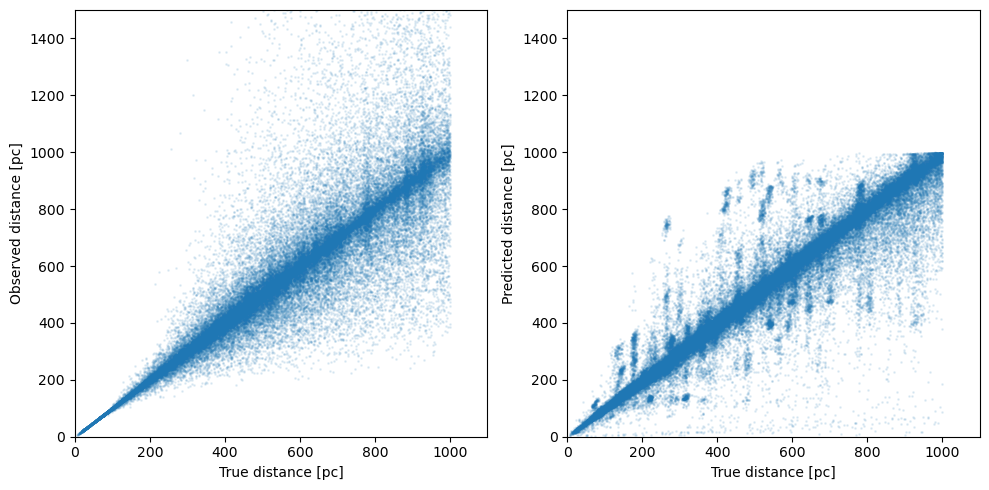

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
lim_x = [0, 1100]
lim_y = [0, 1500]

axes[0].scatter(dist_true, dist_obs, s=1, alpha=0.1)
axes[0].set_xlabel('True distance [pc]')
axes[0].set_ylabel('Observed distance [pc]')
axes[0].set_xlim(lim_x)
axes[0].set_ylim(lim_y)

axes[1].scatter(dist_true, dist_pred, s=1, alpha=0.1)
axes[1].set_xlabel('True distance [pc]')
axes[1].set_ylabel('Predicted distance [pc]')
axes[1].set_xlim(lim_x)
axes[1].set_ylim(lim_y)

plt.tight_layout()

In [36]:
# plt.scatter(logAge_true, logAge_pred, s=100)
# plt.xlabel('True logAge')
# plt.ylabel('Predicted logAge')
# plt.plot([6, 10], [6, 10], 'k--')

# Prepare plots

In [40]:
from astropy.coordinates import SkyCoord, ICRS, Galactic
from astropy import units as u

In [41]:
# Compute predicted X,Y,Z positions
df_val = df.loc[dataset_val.indices]

c_gal = SkyCoord(
    u=df_val.X_obs.values*u.pc, 
    v=df_val.Y_obs.values*u.pc, 
    w=df_val.Z_obs.values * u.pc, 
    frame='galactic',
    representation_type='cartesian'
)

c_icrs = c_gal.transform_to(ICRS())
c_icrs.representation_type = 'spherical'

In [42]:
c = SkyCoord(ra=c_icrs.ra.value*u.deg, dec=c_icrs.dec.value*u.deg, distance=dist_pred * u.pc, frame='icrs')
c = c.transform_to(Galactic())
c.representation_type = 'cartesian'
df_val['X_pred'] = c.u.value
df_val['Y_pred'] = c.v.value
df_val['Z_pred'] = c.w.value

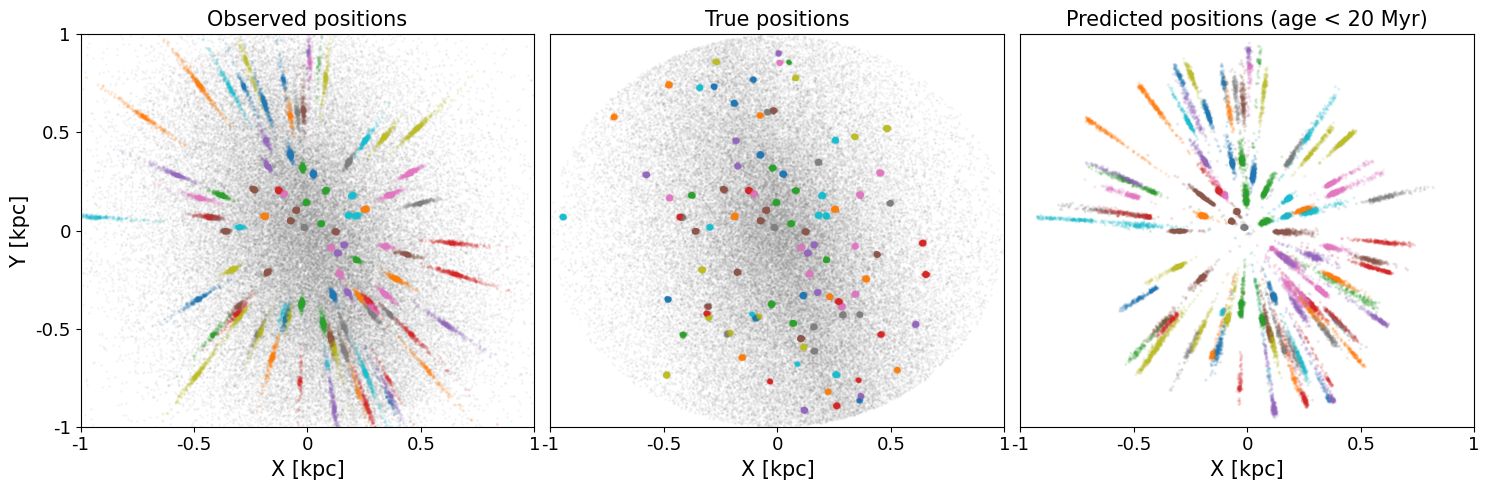

In [53]:
plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=True) #, =0.1, wspace=0.1)
plt.subplot(1, 3, 1)
lim = 1000

cut_labels =  df_val.labels!=8
df_plt = df_val.loc[cut_labels]

# plt.scatter(df_plt.X_obs, df_plt.Y_obs, s=1, alpha=0.05, c='tab:grey') #cmap='viridis')
plt.scatter(df_plt.loc[df_plt.labels==-1, 'X_obs'], df_plt.loc[df_plt.labels==-1, 'Y_obs'], s=1, alpha=0.05, c='tab:grey')
plt.scatter(df_plt.loc[df_plt.labels!=-1, 'X_obs'], df_plt.loc[df_plt.labels!=-1, 'Y_obs'], s=2, alpha=0.1, cmap='tab10', c=df_plt.loc[df_plt.labels!=-1, 'labels'])

plt.xlabel('X [kpc]', fontsize=15)
plt.ylabel('Y [kpc]', fontsize=15)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False, labelbottom=True, labelleft=True)
plt.yticks([-1000, -500, 0, 500, 1000], [-1, -0.5, 0, 0.5, 1], fontsize=13)
plt.xticks([-1000, -500, 0, 500, 1000], [-1, -0.5, 0, 0.5, 1], fontsize=13)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.title('Observed positions', fontsize=15)

plt.subplot(1, 3, 2)
plt.scatter(df_plt.loc[df_plt.labels==-1, 'X'], df_plt.loc[df_plt.labels==-1, 'Y'], s=1, alpha=0.05, c='tab:grey')
plt.scatter(df_plt.loc[df_plt.labels!=-1, 'X'], df_plt.loc[df_plt.labels!=-1, 'Y'], s=2, alpha=0.1, cmap='tab10', c=df_plt.loc[df_plt.labels!=-1, 'labels'])
# plt.scatter(df_val['X'], df_val['Y'], s=2, alpha=0.1, cmap='coolwarm', c=logAge_true)
plt.xlabel('X [kpc]', fontsize=15)
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelbottom=True, labelleft=False)
plt.xticks([-1000, -500, 0, 500, 1000], [-1, -0.5, 0, 0.5, 1], fontsize=13)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.title('True positions', fontsize=15)

plt.subplot(1, 3, 3)
th = 7.8
cut_bg = (df_plt.labels==-1) & (logAge_pred[cut_labels]<th) & (df_val.logAge < th)
cut_sig = (df_plt.labels!=-1) & (logAge_pred[cut_labels]<th) & (df_val.logAge < th)


plt.scatter(df_plt.loc[cut_bg, 'X_pred'], df_plt.loc[cut_bg, 'Y_pred'], s=1, alpha=0.05, c='tab:grey')
plt.scatter(df_plt.loc[cut_sig, 'X_pred'], df_plt.loc[cut_sig, 'Y_pred'], s=2, alpha=0.1, cmap='tab10', c=df_plt.loc[cut_sig, 'labels'])

# plt.scatter(df_plt.loc[logAge_pred[cut_labels]<7.9, 'X_pred'], df_plt.loc[logAge_pred[cut_labels]<7.9, 'Y_pred'], s=1, alpha=0.05, c='k')

plt.xlabel('X [kpc]', fontsize=15)
# Remove ticks
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=False, right=False, labelbottom=True, labelleft=False)
plt.xticks([-1000, -500, 0, 500, 1000], [-1, -0.5, 0, 0.5, 1], fontsize=13)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.title('Predicted positions (age < 20 Myr)', fontsize=15)

plt.tight_layout(w_pad=0.1, h_pad=.5)
# plt.savefig('/Users/ratzenboe/Desktop/figures/observed_vs_true_vs_predicted_noPlx_100clusters.png', dpi=300)

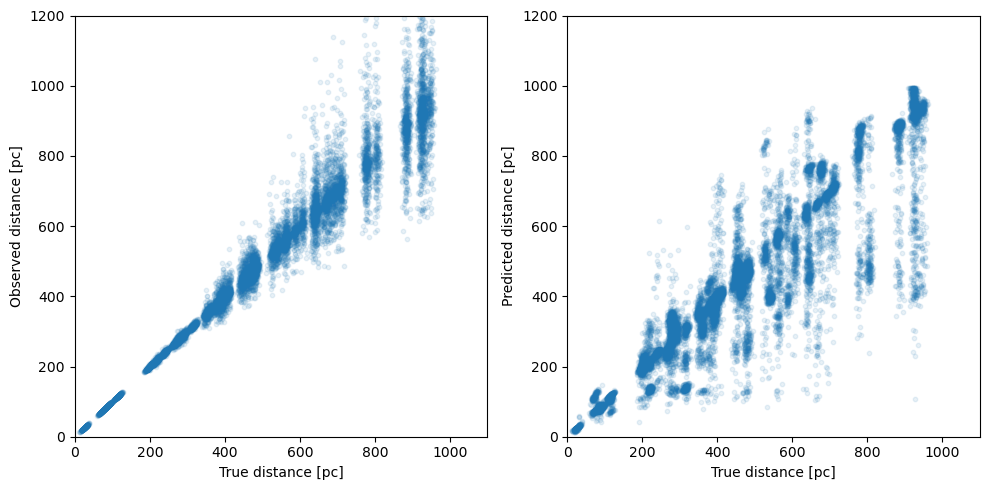

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
lim_x = [0, 1100]
lim_y = [0, 1200]

cut_labels = (df_val.logAge<7.) & (df_val.labels > -1)

axes[0].scatter(dist_true[cut_labels], dist_obs[cut_labels], s=10, alpha=0.1)
axes[0].set_xlabel('True distance [pc]')
axes[0].set_ylabel('Observed distance [pc]')
axes[0].set_xlim(lim_x)
axes[0].set_ylim(lim_y)

axes[1].scatter(dist_true[cut_labels], dist_pred[cut_labels], s=10, alpha=0.1)
axes[1].set_xlabel('True distance [pc]')
axes[1].set_ylabel('Predicted distance [pc]')
axes[1].set_xlim(lim_x)
axes[1].set_ylim(lim_y)

plt.tight_layout()

In [46]:
# for label_i in np.arange(0, 10):
#     cut_l_i = (df_val.labels==label_i)
#     lA_true = 10**df_val.loc[cut_l_i, 'logAge'].median()/1e6
#     dist_i_pred = dist_pred[cut_l_i]
#     linAge_i_pred = 10**logAge_pred[cut_l_i]/1e6,
#     plt.scatter(linAge_i_pred, dist_i_pred, label=f'Label {label_i}', s=10)
#     plt.axvline(lA_true, c='k', ls='--', lw=1)
#     plt.axhline(1000/df_val.loc[cut_l_i, 'parallax'].median(), c='k', ls='--', lw=1)
#     plt.xlabel('Predicted logAge [Myr]')
#     plt.ylabel('Predicted distance [pc]')
#     plt.legend()
#     plt.xlim(0, 80)
#     plt.ylim(0, 1000)
#     plt.show()

In [51]:
dist_pred.shape

(400,)